In [24]:
# load packages
import torch
import math
import torch.nn.functional as F
import matplotlib.pyplot as plt
Device='cpu'
# set dimensionality
data_dim=2
latent_dim=2

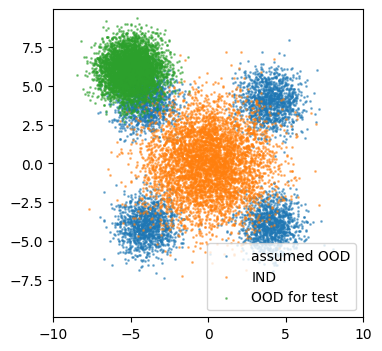

In [25]:
# generate Gaussian mixtures as training data
x_IND=2*torch.randn(5000,2)
x_OOD1=1*torch.randn(1250,2)+torch.as_tensor([4.0,4.0])
x_OOD2=1*torch.randn(1250,2)+torch.as_tensor([4.0,-4.0])
x_OOD3=1*torch.randn(1250,2)+torch.as_tensor([-4.0,4.0])
x_OOD4=1*torch.randn(1250,2)+torch.as_tensor([-4.0,-4.0])
x_OOD=torch.cat([x_OOD1,x_OOD2,x_OOD3,x_OOD4],dim=0)
# generate test data
test_OOD=1*torch.randn(5000,2)+torch.as_tensor([-5.0,6.0])
# visualise
plt.figure(figsize=(4,4))
plt.scatter(x_OOD[:,0],x_OOD[:,1],s=1,alpha=0.5,label='assumed OOD');
plt.scatter(x_IND[:,0],x_IND[:,1],s=1,alpha=0.5,label='IND');
plt.scatter(test_OOD[:,0],test_OOD[:,1],s=1,alpha=0.5,label='OOD for test');
plt.axis("equal");
plt.axis([-10,10,-10,10]);
plt.legend();
plt.savefig("X.png",dpi=250)

In [26]:
# define VAE structure
net_width=100
class Encoder(torch.nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.nonlinear=torch.nn.ReLU()
        self.layer1 = torch.nn.Linear(data_dim,net_width)
        self.layer2 = torch.nn.Linear(net_width,net_width)
        self.layer3 = torch.nn.Linear(net_width,net_width)
        self.layer4 = torch.nn.Linear(net_width,net_width)
        self.layer5_μ = torch.nn.Linear(net_width,latent_dim)
        self.layer5_σ = torch.nn.Linear(net_width,latent_dim)
    def forward(self,x_in):
        x1=self.nonlinear(self.layer1(x_in))
        x2=self.nonlinear(self.layer2(x1))
        x3=self.nonlinear(self.layer3(x2))
        x4=self.nonlinear(self.layer4(x3))
        μ=self.layer5_μ(x4)
        logσ=self.layer5_σ(x4)
        return μ,logσ

class Decoder(torch.nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.nonlinear=torch.nn.ReLU()
        self.layer1 = torch.nn.Linear(latent_dim,net_width)
        self.layer2 = torch.nn.Linear(net_width,net_width)
        self.layer3 = torch.nn.Linear(net_width,data_dim)   
        
    def forward(self,x_in):
        x1=self.nonlinear(self.layer1(x_in))
        x2=self.nonlinear(self.layer2(x1))
        x3=self.layer3(x2)
        return x3

class VAE(torch.nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.EN=Encoder()
        self.DE=Decoder()

    def reparameterization(self, μ, σ):
        epsilon = torch.randn_like(σ).to(Device)      # sampling epsilon        
        z = μ + σ*epsilon                          # reparameterization trick
        return z
        
    def forward(self,x):
        μ, logσ = self.EN(x)
        z = self.reparameterization(μ, torch.exp(logσ)) # takes exponential function (log var -> var)
        x_hat   = self.DE(z)
        x_rec   = self.DE(μ)
        
        return x_rec, x_hat, μ, logσ

vae=VAE()
opt_vae = torch.optim.Adam(vae.parameters(), lr=0.01)
# define loss functions

def repro_loss(x, x_hat):# reproduction loss
    l = (x_hat-x).pow(2).sum(dim=1).sqrt().mean()
    return l
def KL_loss(μ, logσ):    # KL divergence loss
    KLD = (- 0.5 * torch.sum(1 + 2*logσ - μ.pow(2) - (2*logσ).exp(),dim=1))
    return KLD.mean()

In [27]:
# train VAE structure based on IND only
N_iter=3000
batchsize=100
for i in range(N_iter):
    permutation=torch.randperm(len(x_IND))[0:batchsize]
    x=x_IND[permutation,:]
    opt_vae.zero_grad()
    x_rec, x_hat, μ, logσ=vae(x)
    l_rec=repro_loss(x, x_hat)
    l_KL =KL_loss(μ, logσ)
    loss= l_rec + 0.1*l_KL
    loss.backward()
    opt_vae.step()
    if i%(N_iter//100)==0:
        print([round(l_rec.item(),4),round(l_KL.item(),4)],end=" ~ ")#",",round(l_KL.item(),4),

[2.3074, 0.0021] ~ [0.6984, 4.0725] ~ [0.4384, 4.3194] ~ [0.4112, 4.3739] ~ [0.3267, 5.0285] ~ [0.3341, 4.5094] ~ [0.3435, 4.6736] ~ [0.3381, 4.5794] ~ [0.2912, 4.7034] ~ [0.3539, 4.6505] ~ [0.3774, 4.2862] ~ [0.363, 4.501] ~ [0.3164, 4.5558] ~ [0.3056, 4.6926] ~ [0.2798, 5.0937] ~ [0.3337, 4.5116] ~ [0.3456, 4.3424] ~ [0.352, 4.2574] ~ [0.2853, 4.5708] ~ [0.2941, 4.5703] ~ [0.3271, 4.4317] ~ [0.292, 4.6149] ~ [0.382, 4.3981] ~ [0.2379, 5.0213] ~ [0.2862, 4.6374] ~ [0.3458, 4.5109] ~ [0.2913, 4.7718] ~ [0.3353, 4.6618] ~ [0.3139, 4.6022] ~ [0.3816, 4.4011] ~ [0.2815, 4.8485] ~ [0.2425, 5.0733] ~ [0.3334, 4.6785] ~ [0.2578, 4.7373] ~ [0.3715, 4.5545] ~ [0.3017, 4.698] ~ [0.3413, 4.5056] ~ [0.2684, 4.6676] ~ [0.3184, 4.635] ~ [0.2593, 4.8391] ~ [0.3045, 4.4751] ~ [0.2913, 4.6448] ~ [0.2622, 4.9315] ~ [0.3145, 4.6257] ~ [0.3036, 4.6249] ~ [0.2555, 4.7596] ~ [0.3149, 4.8062] ~ [0.2665, 4.6634] ~ [0.2744, 4.6612] ~ [0.338, 4.6293] ~ [0.2683, 4.7228] ~ [0.2713, 4.6356] ~ [0.2907, 4.6369] ~ [

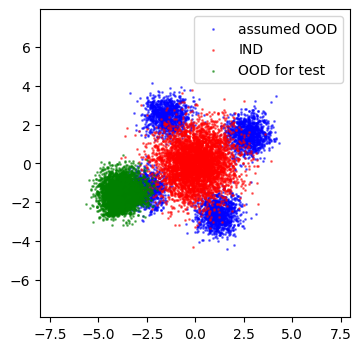

In [28]:
# visualise assumed IND and OOD data in latent space
_, _, z_IND, _=vae(x_IND)
_, _, z_OOD, _=vae(x_OOD)
_, _, z_test_OOD, _=vae(test_OOD)
z_IND=z_IND.detach()
z_OOD=z_OOD.detach()
z_test_OOD=z_test_OOD.detach()
#plt.hist(z_OOD.flatten(),range=(-1,1),bins=100);
#plt.hist(z_IND.flatten(),range=(-1,1),bins=100);
plt.figure(figsize=(4,4))
plt.scatter(z_OOD[:,0],z_OOD[:,1],s=1,alpha=0.5,c='b',label='assumed OOD');
plt.scatter(z_IND[:,0],z_IND[:,1],s=1,alpha=0.5,c='r',label='IND');
plt.scatter(z_test_OOD[:,0],z_test_OOD[:,1],s=1,alpha=0.5,c='g',label='OOD for test');
plt.axis("equal");
plt.axis([-8,8,-8,8]);
plt.legend();
plt.savefig("Z.png",dpi=250)

In [32]:
# save IND data and trained VAE structure
torch.save(z_IND,"z_IND.pt")
torch.save(vae,"vae.pt")

torch.save(x_IND,"x_IND.pt")
torch.save(x_OOD,"x_OOD.pt")
torch.save(test_OOD,"test_OOD.pt")